# Tutorial 2

In [169]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from matplotlib import pyplot as plt

## Exercise 2: Swendsen-Wang algorithm for the 2D Ising model

The goal of this exercise is to implement the Swendsen-Wang algorithm for the 2D Ising model. Recall that the update of the Swendsen-Wang algorithm works as follows:
- Assign to each bond $b$ a variable $w_b \in\{0,1\}$, where 1 means "connected" and 0 means "disconnected". If the spins connected by the bond $b=(n, m)$ between index $n$ and $m$ are anti-parallel, always choose $w_b=0$, If the spins are parallel, choose $w_b=0$ with probability $e^{-2 \beta J}$, where $\beta=\frac{1}{k_B T}$. In terms of conditional probabilities:
$$
\begin{array}{ll}
p\left(w_b=0 \mid \sigma_n \neq \sigma_m\right)=1, & p\left(w_b=0 \mid \sigma_n=\sigma_m\right)=e^{-2 \beta J}, \\
p\left(w_b=1 \mid \sigma_n \neq \sigma_m\right)=0, & p\left(w_b=1 \mid \sigma_n=\sigma_m\right)=1 .-e^{-2 \beta J} .
\end{array}
$$
- Interpreting the connected bonds as edges of a graph (where 0 means no edge) and the spins as node, find "clusters" of spins, i.e., connected components of the graph.
- Flip each cluster (= connected component) with probability $p=0.5$. Notice that a single spin is also a "cluster".

After the update, do a measurement (if the system is already thermalized) and continue with the next update.

a) Setup the system by writing these three functions
- def $x y \_2 \_i d x($ int $x$, int $y) \rightarrow$ int idx
- def idx_2_xy(int $i d x) \rightarrow$ int $x$, int $y$
- def create_bond_indices(int Lx, int Ly) $\rightarrow$ list bond_indices
Since we need to identify clusters, it is better to label the lattice sites $(x, y)$ by a single integer number $n=n(x, y)=x \cdot L_y+y=0,1, \cdots, N-1$ where $N=L_x \cdot L_y$. The inverse mapping is given by $x(n)=n / / L_y$ (integer division, rounding down) and $y(n)=n \bmod L_y$. Create an array that contains the indices of each bond $(n, m)$ of the square lattice with periodic boundary conditions exactly once. There are in totals $2\mathrm{N}$ bonds and we indicate each bond by two indices. The array for bond indices is just for keeping track of the indices of the bond and is immutable. It should not be confused with the bond configuration, i.e. each bond connected or not. The array for bond indices should have shape $(2 N, 2)$, e.g.
$$
\overbrace{\left(\begin{array}{cc}
0, & 1 \\
1, & 2 \\
\vdots & \vdots \\
L_y-1 & 0 \\
\vdots & \vdots
\end{array}\right)}^{\text {size }=2}
$$

In [6]:
def xy_2_idx(x, y, Ly):
    return x*Ly + y

def idx_2_xy(idx, Ly):
    return int(np.floor(idx/Ly)), idx%Ly

In [13]:
def create_bond_indices(Lx, Ly):
    
    bond_indices = []

    # horizontal connection
    for i in range(Lx):
        for j in range(Ly):
            bond_indices += [[xy_2_idx(i, j, Ly), xy_2_idx(i, (j+1)%Ly, Ly)]]

    # vertical connection
    for i in range(Ly):
        for j in range(Lx):
            bond_indices += [[xy_2_idx(j, i, Lx), xy_2_idx((j+1)%Lx, i, Lx)]]
    
    return np.array(bond_indices)

In [20]:
# Testing the functions

Lx = 4
Ly = 5
N = Lx*Ly

print(create_bond_indices(Lx,Ly))
print(create_bond_indices(Lx,Ly).shape)
print(create_bond_indices(Lx,Ly).shape == (2*N, 2))

[[ 0  1]
 [ 1  2]
 [ 2  3]
 [ 3  4]
 [ 4  0]
 [ 5  6]
 [ 6  7]
 [ 7  8]
 [ 8  9]
 [ 9  5]
 [10 11]
 [11 12]
 [12 13]
 [13 14]
 [14 10]
 [15 16]
 [16 17]
 [17 18]
 [18 19]
 [19 15]
 [ 0  4]
 [ 4  8]
 [ 8 12]
 [12  0]
 [ 1  5]
 [ 5  9]
 [ 9 13]
 [13  1]
 [ 2  6]
 [ 6 10]
 [10 14]
 [14  2]
 [ 3  7]
 [ 7 11]
 [11 15]
 [15  3]
 [ 4  8]
 [ 8 12]
 [12 16]
 [16  4]]
(40, 2)
True


b) Initialize a 1D array for the spin states $\sigma_n$ (having random entries $\pm 1$ ).

In [40]:
spin_config = np.random.randint(2, size=Lx*Ly)*2-1
spin_config, spin_config.shape

(array([ 1, -1, -1, -1,  1,  1, -1, -1,  1, -1, -1, -1,  1,  1,  1,  1, -1,
        -1,  1, -1]),
 (20,))

c) Write a function that determines, i.e. sample, the bond configuration $w_b$ for each of the bonds, given the spin configuration.
def update_bond_config(np.ndarray spin_config, np.ndarray bond_indices, float $\mathrm{T}$ ) $\rightarrow$ np.ndarray bond_config

In [51]:
def cond_prob(sigma_n, sigma_m, T):
    if sigma_n != sigma_m:
        return 0
    
    else:
        k = 1
        beta = 1/(k*T)
        J = 1
        if np.exp(-2*beta*J) > np.random.rand():
            return 0
        else:
            return 1

In [67]:
def update_bond_config(spin_config, bond_indices, T):

    bond_config = []
    # iterate for every bond (edge)
    for i in range(bond_indices.shape[0]):
        # the spin state for both of the spins connected in this particular bond
        sigma_n = spin_config[bond_indices[i][0]]
        sigma_m = spin_config[bond_indices[i][1]]

        # using the conditional probability defined, determine whether the bond is "connected" or "disconnected"
        bond_config += [cond_prob(sigma_n, sigma_m, T)]

    return np.array(bond_config)

In [137]:
# Testing the functions

Lx = 4
Ly = 5
N = Lx*Ly
T = 10

spin_config = np.random.randint(2, size=Lx*Ly)*2-1
print(spin_config)
bond_config = update_bond_config(spin_config, bond_indices=create_bond_indices(Lx,Ly), T=T)
print(bond_config.shape)
print(bond_config)

[-1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1  1  1 -1  1  1]
(40,)
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0]


d) To determine the connected components, you can use the function scipy.sparse.csgraph.connected_components. Look up the documentation of the function online. The graph is represented by a sparse matrix of the type scipy.sparse.csr_matrix. You can use the initialization of the form csr_matrix((bond_config, (bond_indices $[:, 0]$, bond_indices $[:, 1])$ ), shape=(N, N)). Don't forget to add the transposed to obtain a symmetric graph. Using the result of connected_components, flip each of the determined clusters with probability $p=0.5$. Collect the code in a function performing one update with the Swendsen-Wang algorithm.

In [133]:
def swendsen_wang_update(spin_config, bond_indices, T, Lx, Ly):

    spin_config_new = spin_config.copy()
    
    N = Lx*Ly

    # sampling the bond config
    bond_config = update_bond_config(spin_config, bond_indices, T)

    # identify clusters of connected spins
    csr_graph = csr_matrix((bond_config, (bond_indices[:, 0], bond_indices[:, 1])), shape=(N,N))
    csr_graph = csr_graph + csr_graph.transpose()

    n_clusters, labels = connected_components(csgraph=csr_graph, directed=False, return_labels=True)

    # for each cluster, flip the all the spins inside that cluster with probability 0.5
    for i in range(n_clusters):
        if np.random.rand() < 0.5:
            spin_config_new[labels==i] = spin_config[labels==i]*-1

    return spin_config_new

In [140]:
# Test the code

Lx = 3
Ly = 3
N = Lx*Ly
T = 10

spin_config_init = np.random.randint(2, size=Lx*Ly)*2-1
bond_indices = create_bond_indices(Lx,Ly)
bond_config = update_bond_config(spin_config, bond_indices=create_bond_indices(Lx,Ly), T=T)

csr_graph = csr_matrix((bond_config, (bond_indices[:, 0], bond_indices[:, 1])), shape=(N,N))
csr_graph = csr_graph + csr_graph.transpose()

print(spin_config_init)
print(csr_graph)

[-1  1  1 -1  1  1  1  1  1]
  (2, 8)	1
  (6, 7)	1
  (7, 6)	1
  (7, 8)	1
  (8, 2)	1
  (8, 7)	1


In [141]:
# Update it once

swendsen_wang_update(spin_config_init, bond_indices, T, Lx, Ly)

array([ 1,  1,  1,  1, -1, -1,  1,  1,  1])

e) Write functions to measure the energy and magnetization.

In [144]:
# function to determine all the neighbouring sites' index given a certain site index
# to avoid double counting, "neighbour" here is define as the sites below and to the right of a certain site

def neighbour(idx, Ly):

    neighbouring_idx = []

    # the coordinate of the site
    x, y = idx_2_xy(idx, Ly)

    # the index of the neighbouring sites
    # the index for the one to the right
    neighbouring_idx += [xy_2_idx(x, (y+1)%Ly, Ly)]
    # the index for the one below
    neighbouring_idx += [xy_2_idx((x+1)%Lx, y, Ly)]

    return neighbouring_idx

In [149]:
def energy(spin_config, Ly):
    
    J = 1
    
    E = 0
    # iterate for all spin sites
    for i in range(len(spin_config)):
        neighbouring_sites = neighbour(i, Ly)
        E += -1.*J*spin_config[i]*(spin_config[neighbouring_sites[0]] + spin_config[neighbouring_sites[1]])
    
    return E

In [155]:
def magnetization(spin_config, Lx, Ly):

    M = np.sum(spin_config)/(Lx*Ly)

    return M

In [159]:
# Test the code

print(Lx, Ly)
print(spin_config_init)

print(energy(spin_config_init, Ly), magnetization(spin_config_init, Lx, Ly))

3 3
[-1  1  1 -1  1  1  1  1  1]
-6.0 0.5555555555555556


f) Write a function to run the whole Monte Carlo simulation at given temperature, returning arrays with all measured values $E$ and $M$. Plot the mean values for different temperatures and make sure you get (roughly) the same results as last week. (Begin the comparison with small systems!)

In [166]:
def swendsen_wang_loop(spin_config, bond_indices, T, Lx, Ly, N_sweeps, N_eq, N_flips):
    
    E_list = []
    M_list = []

    for step in range(N_sweeps + N_eq):
        spin_config = swendsen_wang_update(spin_config, bond_indices, T, Lx, Ly)

        if step >= N_eq and np.mod(step, N_flips) == 0:
            # measurement
            E = energy(spin_config, Ly)
            M = magnetization(spin_config, Lx, Ly)
            E_list.append(E)
            M_list.append(M)

    return spin_config, np.array(E_list), np.array(M_list)

In [167]:
# Set parameters here
Lx = 3
Ly = 3
N_sweeps = 5000  # Number of steps for the measurements = number of steps to be done after N_eq is reached
N_eq = 1000  # Number of equilibration steps before the measurements start = wait until this much iteration first before doing the 1st measurement
N_flips = 10  # Number of steps between measurements = after N_eq is reached, do measurement every N_flips steps
N_bins = 10  # Number of bins use for the error analysis = do this much time and average the result to get a better estimation for the value (reducing statistical error)
T_range = np.arange(1.5, 3.1, 0.1) # temperature of the system, [1.5, 3.1) with 0.1 increment

spin_config = np.random.randint(2, size=Lx*Ly)*2-1
bond_indices = create_bond_indices(Lx,Ly)

# do iteration for every temperature chosen
E_list = []
M_list = []
for T in T_range:
    # for every temperature, do the loop for N_bins times and calculate the average
    E_list_bin = []
    M_list_bin = []
    for k in range(N_bins):
            # do the Swendsen-Wang algo, get the system energy & magnetization from every measurement
            spin_config, Es, Ms = swendsen_wang_loop(spin_config, bond_indices, T, Lx, Ly, N_sweeps, N_eq, N_flips)

            # averaging all the measurement
            mean_E = np.mean(Es)
            mean_M = np.mean(Ms)
            #mean_E2 = np.mean(Es**2)
            #mean_M2 = np.mean(Ms**2)

            E_list_bin.append(mean_E)
            M_list_bin.append(mean_M)

    # average the results from N_bins times of running for statistical reason
    E_list.append([np.mean(E_list_bin), np.std(E_list_bin) / np.sqrt(N_bins)])
    M_list.append([np.mean(M_list_bin), np.std(M_list_bin) / np.sqrt(N_bins)])

    print(T, E_list[-1], M_list[-1])


1.5 [-17.607999999999997, 0.018101933598375662] [0.030177777777777776, 0.015117181787131659]
1.6 [-17.287200000000002, 0.028787775183226737] [-0.024133333333333336, 0.010539997891629557]
1.7000000000000002 [-17.0688, 0.021797614548385722] [0.011200000000000003, 0.01118072415331818]
1.8000000000000003 [-16.7208, 0.05060213434233797] [0.014755555555555558, 0.010917205810831332]
1.9000000000000004 [-16.378400000000003, 0.04975524092997663] [0.01008888888888889, 0.01162611789394683]
2.0000000000000004 [-15.893600000000001, 0.0706364212003977] [0.018711111111111105, 0.011723809265921366]
2.1000000000000005 [-15.359200000000001, 0.042157039744270416] [0.014755555555555558, 0.012118069356884848]
2.2000000000000006 [-14.868799999999998, 0.06777090821289022] [0.007333333333333336, 0.00788090362682533]
2.3000000000000007 [-14.339200000000002, 0.050459647244109875] [0.007244444444444444, 0.008428769076688963]
2.400000000000001 [-13.895199999999999, 0.07911065667784588] [-0.015377777777777777, 0.0

2.269185314213022


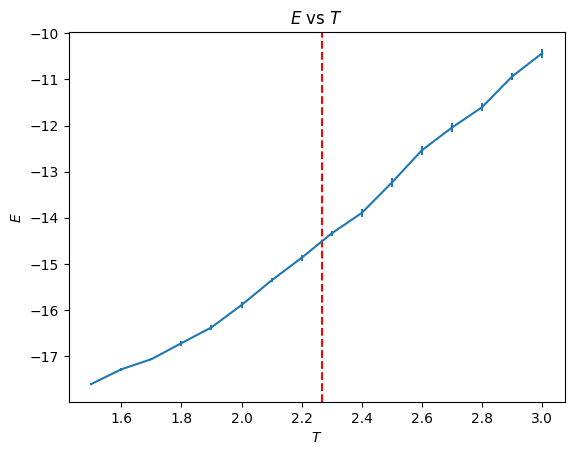

In [171]:
 # Plot the results
E_list = np.array(E_list)
plt.errorbar(T_range, E_list[:, 0], E_list[:, 1]) # plot (with error bar = std dev) the average energy variance of the system vs temperature

Tc = 2. / np.log(1. + np.sqrt(2)) # temperature where the critical point happens
print(Tc)

plt.axvline(Tc, color='r', linestyle='--')
plt.xlabel('$T$')
plt.ylabel('$E$')
plt.title('$E$ vs $T$')
plt.show()

2.269185314213022


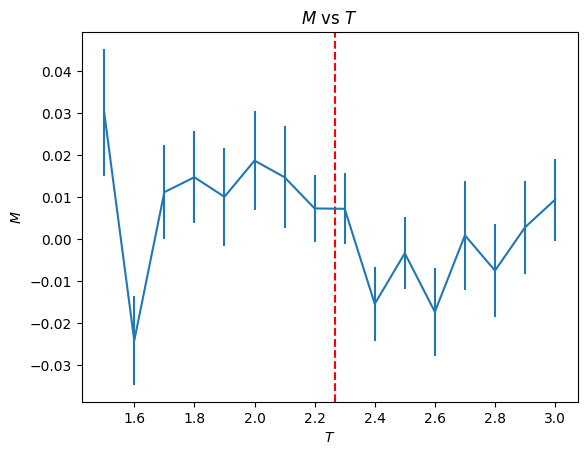

In [172]:
 # Plot the results
M_list = np.array(M_list)
plt.errorbar(T_range, M_list[:, 0], M_list[:, 1]) # plot (with error bar = std dev) the average magnetization variance of the system vs temperature

Tc = 2. / np.log(1. + np.sqrt(2)) # temperature where the critical point happens
print(Tc)

plt.axvline(Tc, color='r', linestyle='--')
plt.xlabel('$T$')
plt.ylabel('$M$')
plt.title('$M$ vs $T$')
plt.show()

In [177]:
# Set parameters here
Lx = 3
Ly = 3
N_sweeps = 5000  # Number of steps for the measurements = number of steps to be done after N_eq is reached
N_eq = 1000  # Number of equilibration steps before the measurements start = wait until this much iteration first before doing the 1st measurement
N_flips = 10  # Number of steps between measurements = after N_eq is reached, do measurement every N_flips steps
N_bins = 10  # Number of bins use for the error analysis = do this much time and average the result to get a better estimation for the value (reducing statistical error)
T_range = np.arange(1.5, 3.1, 0.1) # temperature of the system, [1.5, 3.1) with 0.1 increment

spin_config = np.random.randint(2, size=Lx*Ly)*2-1
bond_indices = create_bond_indices(Lx,Ly)

# do iteration for every temperature chosen
C_list = []
for T in T_range:
    # for every temperature, do the loop for N_bins times and calculate the average
    C_list_bin = []
    for k in range(N_bins):
            # do the Swendsen-Wang algo, get the system energy & magnetization from every measurement
            spin_config, Es, _ = swendsen_wang_loop(spin_config, bond_indices, T, Lx, Ly, N_sweeps, N_eq, N_flips)

            # averaging all the measurement
            mean_E = np.mean(Es)
            mean_E2 = np.mean(Es**2)

            C_list_bin.append(1. / T**2. / (Lx*Ly) * (mean_E2 - mean_E**2))

    # average the results from N_bins times of running for statistical reason
    C_list.append([np.mean(C_list_bin), np.std(C_list_bin) / np.sqrt(N_bins)])

    print(T, C_list[-1])


1.5 [0.2356239802469137, 0.01185061409948919]
1.6 [0.2600297222222219, 0.017692885898786207]
1.7000000000000002 [0.3295286428296806, 0.017209577432252036]
1.8000000000000003 [0.37182046639231786, 0.01150268798811801]
1.9000000000000004 [0.4716027823945832, 0.020074171669529923]
2.0000000000000004 [0.5401601777777777, 0.017310030566327756]
2.1000000000000005 [0.5790945427059708, 0.013936694783985246]
2.2000000000000006 [0.610179467401285, 0.00963476713075309]
2.3000000000000007 [0.6769613778617933, 0.010083354396725568]
2.400000000000001 [0.6352898765432095, 0.012896431971356696]
2.500000000000001 [0.6466800071111107, 0.012089460139907204]
2.600000000000001 [0.6542514661406964, 0.008501356895757543]
2.700000000000001 [0.638157939338515, 0.006695006221776782]
2.800000000000001 [0.6165717006802716, 0.00851345235628123]
2.9000000000000012 [0.5938259743691366, 0.0064445191824818605]
3.0000000000000013 [0.5488858074074071, 0.0061755783243168105]


2.269185314213022


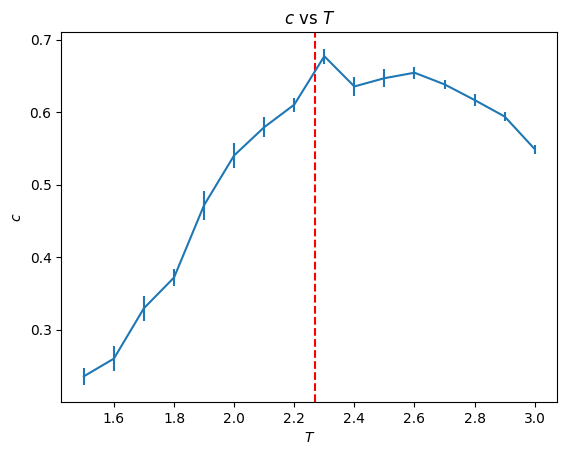

In [178]:
 # Plot the results
C_list = np.array(C_list)
plt.errorbar(T_range, C_list[:, 0], C_list[:, 1]) # plot (with error bar = std dev) the average energy variance of the system vs temperature

Tc = 2. / np.log(1. + np.sqrt(2)) # temperature where the critical point happens
print(Tc)

plt.axvline(Tc, color='r', linestyle='--')
plt.xlabel('$T$')
plt.ylabel('$c$')
plt.title('$c$ vs $T$')
plt.show()

g) Optionally: If in previous functions, you construct the function with for loop and in else clauses, now is a good time to optimize the code with numba.jit.

h) Measure and plot the auto-correlation of the energy
$$
C_E(\delta)=\frac{\left\langle E_{t+\delta} E_t\right\rangle_t-\left\langle E_t\right\rangle_t^2}{\left\langle\left(E_t\right)^2\right\rangle_t-\left\langle E_t\right\rangle_t^2}
$$
versus $\delta$ (and similarly for the magnetization) for $T$ right at, above, and below the critical temperature $T_c$.

In [200]:
def auto_corel(Es, t, delta):
    
    Es_t = Es[:t]
    Es_t_delta = Es[delta:(t+delta)]

    mean_E_t = np.mean(Es_t)
    mean_E2_t = np.mean(Es_t**2)
    mean_E_t_delta_E_t = np.mean(Es_t_delta*Es_t)


    C_E = (mean_E_t_delta_E_t - mean_E_t**2)/(mean_E2_t - mean_E_t**2)

    return C_E

In [191]:
# Set parameters here
Lx = 3
Ly = 3
N_sweeps = 5000  # Number of steps for the measurements = number of steps to be done after N_eq is reached
N_eq = 1000  # Number of equilibration steps before the measurements start = wait until this much iteration first before doing the 1st measurement
N_flips = 10  # Number of steps between measurements = after N_eq is reached, do measurement every N_flips steps
N_bins = 10  # Number of bins use for the error analysis = do this much time and average the result to get a better estimation for the value (reducing statistical error)
Tc = 2. / np.log(1. + np.sqrt(2)) # temperature where the critical point happens, around 2.27
T_range = [Tc-1, Tc, Tc+1]

spin_config = np.random.randint(2, size=Lx*Ly)*2-1
bond_indices = create_bond_indices(Lx,Ly)

# do iteration for every temperature chosen
Es_ave_list = []
for T in T_range:
    # for every temperature, do the loop for N_bins times and calculate the average
    Es_list_bin = []
    for k in range(N_bins):
            # do the Swendsen-Wang algo, get the system energy & magnetization from every measurement
            spin_config, Es, _ = swendsen_wang_loop(spin_config, bond_indices, T, Lx, Ly, N_sweeps, N_eq, N_flips)

            # collect all the measurement
            Es_list_bin += [Es]

    # average the results from N_bins times of running for statistical reason
    Es_ave = np.average(Es_list_bin, axis=0)

    Es_ave_list += [Es_ave]

    print(T, Es_ave_list[-1])

1.269185314213022 [-18.  -16.4 -18.  -18.  -16.4 -17.2 -18.  -18.  -17.2 -17.2 -18.  -18.
 -18.  -18.  -18.  -18.  -18.  -18.  -18.  -18.  -18.  -18.  -17.2 -18.
 -18.  -18.  -18.  -18.  -18.  -18.  -17.2 -18.  -17.2 -18.  -18.  -17.2
 -16.4 -18.  -18.  -18.  -18.  -16.8 -18.  -18.  -18.  -18.  -18.  -17.2
 -18.  -18.  -18.  -18.  -18.  -18.  -18.  -18.  -18.  -18.  -18.  -18.
 -18.  -18.  -16.8 -18.  -18.  -18.  -18.  -18.  -18.  -18.  -18.  -18.
 -17.2 -18.  -17.2 -18.  -18.  -18.  -18.  -18.  -18.  -18.  -18.  -18.
 -18.  -18.  -18.  -18.  -18.  -18.  -18.  -18.  -18.  -18.  -18.  -18.
 -18.  -18.  -17.2 -18.  -18.  -18.  -18.  -18.  -17.2 -18.  -18.  -18.
 -17.2 -18.  -18.  -17.2 -18.  -18.  -18.  -17.2 -18.  -18.  -18.  -17.2
 -18.  -16.8 -18.  -18.  -18.  -18.  -18.  -18.  -18.  -17.2 -18.  -17.2
 -18.  -18.  -18.  -17.2 -16.4 -18.  -17.2 -18.  -17.2 -16.4 -18.  -18.
 -18.  -18.  -18.  -18.  -18.  -18.  -18.  -18.  -18.  -18.  -17.2 -18.
 -17.2 -18.  -17.2 -18.  -18.  -18.  -18. 

In [195]:
len(Es_ave_list)

3

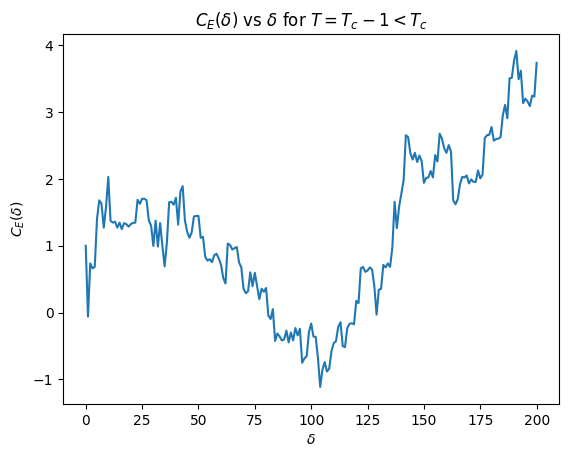

In [222]:
# For temperature = Tc-1 < Tc

t = 300
max_delta = Es_ave_list[0].shape[0] - t
auto_corel_list = [auto_corel(Es_ave_list[0], t=t, delta=i) for i in range(max_delta + 1)]


plt.plot([i for i in range(max_delta+1)], auto_corel_list)
plt.xlabel('$δ$')
plt.ylabel('$C_E(δ)$')
plt.title('$C_E(δ)$ vs $δ$ for $T=T_c-1<T_c$')
plt.show()

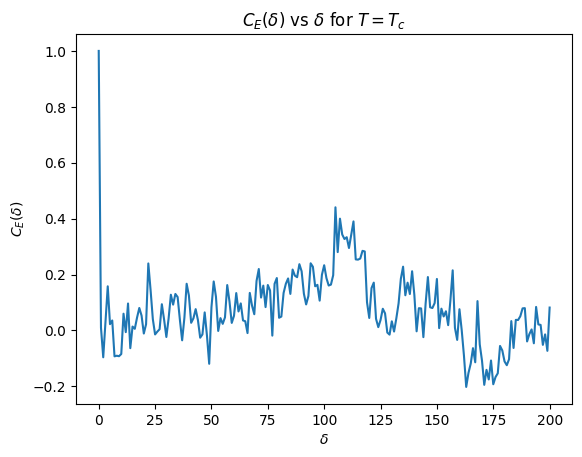

In [223]:
# For temperature = Tc

t = 300
max_delta = Es_ave_list[1].shape[0] - t
auto_corel_list = [auto_corel(Es_ave_list[1], t=t, delta=i) for i in range(max_delta + 1)]


plt.plot([i for i in range(max_delta+1)], auto_corel_list)
plt.xlabel('$δ$')
plt.ylabel('$C_E(δ)$')
plt.title('$C_E(δ)$ vs $δ$ for $T=T_c$')
plt.show()

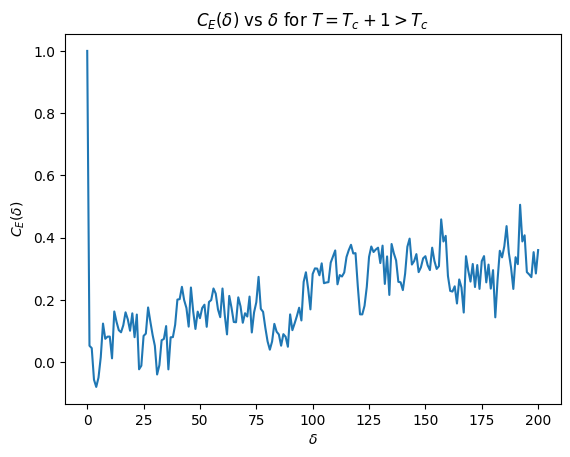

In [224]:
# For temperature = Tc+1 > Tc

t = 300
max_delta = Es_ave_list[2].shape[0] - t
auto_corel_list = [auto_corel(Es_ave_list[2], t=t, delta=i) for i in range(max_delta + 1)]


plt.plot([i for i in range(max_delta+1)], auto_corel_list)
plt.xlabel('$δ$')
plt.ylabel('$C_E(δ)$')
plt.title('$C_E(δ)$ vs $δ$ for $T=T_c+1>T_c$')
plt.show()

i) Recreate the the auto-correlation plots for the update with the Metropolis algorithm. Notice that to compare the global update algorithm, e.g. Swendsen Wang algorithm, with the local update algorithm, e.g. Metropolis algorithm, the result of Metropolis algorithm should be measured with $N=L_x \cdot L_y$ updates.